Ипортирум все необходимые библиотеки 

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import random
import json
import os
import pathlib
import shutil
from sklearn.model_selection import train_test_split
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import yaml

In [2]:
TRAIN_DIR = os.path.abspath('dataset/trainv4')

Визуализирум данные разметки. Разметка в формате COCO.

In [3]:
def visualise_random_dataset_image(coco_dir):
    coco_json_path = os.path.join(coco_dir, 'annotations', 'instances_default.json')
    images_path = os.path.join(coco_dir, 'images')


    with open(coco_json_path) as f:
        data = json.load(f)

    random_image = random.choice(data["images"])
    img_id = random_image["id"]
    image_full_path = os.path.join(images_path, random_image['file_name'])
    image = cv2.imread(image_full_path)


    anns = [a for a in data["annotations"] if a["image_id"] == img_id]

    color_mask = np.zeros_like(image)

    for ann in anns:
        color = (random.randint(0,255), random.randint(0,255),random.randint(0,255))
        for seg in ann['segmentation']:
            pts = np.array(seg, np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(color_mask, [pts], color=color)

    alpha = 0.5
    result = cv2.addWeighted(image, 1, color_mask, alpha, 0)
    return result

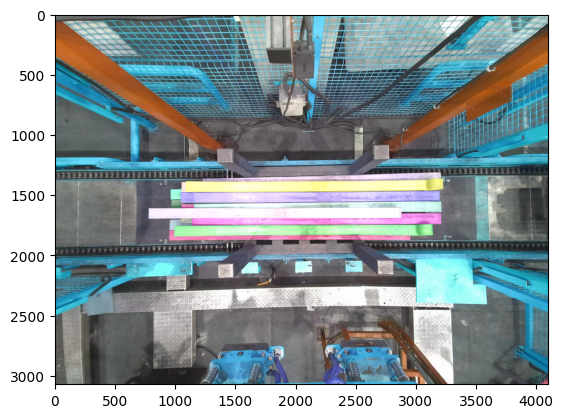

In [4]:
plt.imshow(visualise_random_dataset_image('dataset/coco/'))

Подготавливаем данные для обучения

In [5]:
def coco2yolo_seg(coco_dir, output_dir, set_category_to_0=True):

    coco_json_path = os.path.join(coco_dir, 'annotations', 'instances_default.json')
    images_path = os.path.join(coco_dir, 'images')


    with open(coco_json_path) as f:
        data = json.load(f)

    train_image_dir = os.path.join(output_dir, 'images', 'train')
    train_labels_dir = os.path.join(output_dir, 'labels', 'train')

    val_image_dir = os.path.join(output_dir, 'images', 'val')
    val_labels_dir = os.path.join(output_dir, 'labels', 'val')

    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_image_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    all_images_id = []
    for img in data["images"]:
        img_id = img["id"]
        all_images_id.append(img_id)

    train, val = train_test_split(all_images_id,test_size=0.1)


    for img in data["images"]:
        img_id = img["id"]
        if img_id in train:
            image_dir = train_image_dir
            labels_dir = train_labels_dir
        else:
            image_dir = val_image_dir
            labels_dir = val_labels_dir


        img_w, img_h = img["width"], img["height"]
        anns = [a for a in data["annotations"] if a["image_id"] == img_id]

        image_full_path = os.path.join(images_path, img['file_name'])
        img_file_name = pathlib.Path(img['file_name']).stem

        with open(f"{labels_dir}/{img_file_name}.txt", "w") as f:
            for ann in anns:
                if set_category_to_0:
                    class_id = 0
                else:
                    class_id = ann["category_id"] - 1  # COCO starts from 1, YOLO from 0
                seg = ann["segmentation"][0]
                # Нормализация координат
                normalized_seg = [f"{x / img_w:.6f} {y / img_h:.6f}" for x, y in zip(seg[::2], seg[1::2])]

                f.write(f"{class_id} {' '.join(normalized_seg)}\n")

        shutil.copy2(image_full_path, image_dir)

In [6]:
coco2yolo_seg("dataset/coco/",  TRAIN_DIR)

Подготавливаем конфигурационные параметры для обучения. Можно изменить количество эпох, батчсайз и тп

In [7]:
dataset = {'path': TRAIN_DIR,
  'train': 'images/train',
  'val': 'images/val',
  'names': {0: 'spring'}}

In [8]:
config = {'model_params': {'model': 'yolo11s-seg.pt'},
           'train_params': {'data': f'{TRAIN_DIR}/dataset.yaml',
                  'epochs': 100,
                  'patience': 0,
                  'batch': 32,
                  'imgsz': 1280,
                  'save': True,
                  'save_period': -1,
                  'cache': True,
                  'device': 0,
                  'lr0': 0.001,
                  'workers': 8,
                  'project': 'Ressors',
                  'name': 'Ressors_train2',
                  'exist_ok': True,
                  'pretrained': True,
                  'optimizer': 'Adam',
                  'verbose': True,
                  'seed': 28,
                  'label_smoothing': 0,
                  'single_cls': False,
                  'multi_scale': False,
                  'nbs': 64,
                  'val': True,
                  'plots': True,
                  'degrees': 0,
                  'translate': 0.0,
                   'scale': 0.5,
                   'shear': 0,
                   'mosaic': 0.0,
                   'mixup': 0.0,
                    'flipud': 0.5,
                    'fliplr': 0.5,
                     'hsv_h': 0.5,
                      'hsv_s': 0.5,
                      'hsv_v': 0.5}}

In [9]:
with open(f'{TRAIN_DIR}/dataset.yaml', 'w') as f:
    yaml.dump(dataset, f)

In [10]:
with open(f'{TRAIN_DIR}/config.yaml', 'w') as f:
    yaml.dump(config, f)

Train

In [ ]:
cfg = OmegaConf.load(f'{TRAIN_DIR}/config.yaml')

model = YOLO(**cfg.model_params)
model.train(**dict(cfg.train_params))

Визуализация обученой модели 

In [ ]:
yolo_save_dir = config['train_params']['project']
project_weight_dir = config['train_params']['name']

model = YOLO(f'{yolo_save_dir}/{project_weight_dir}/weights/best.pt')


val_images = pathlib.Path(f'{TRAIN_DIR}/images/val').glob('*.png')

for image in val_images:
    image = cv2.imread(image)
    h,w, c = image.shape
    results = model(image,
                    imgsz=1280,
                    device='cuda:0')

    masks = results[0].masks.data.cpu().numpy()

    for i, mask in enumerate(masks):
        color = (random.randint(0,255), random.randint(0,255),random.randint(0,255))
        mask = cv2.resize(mask, (w,h))

        color_mask = np.zeros_like(image, dtype=np.uint8)
        color_mask[mask > 0] = color
        image = cv2.addWeighted(image, 1.0, color_mask, 0.2, 0)


        binary_mask = (mask > 0).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image, contours, -1, color, 7)
    plt.imshow(image)
    plt.show()